### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [22]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
import cv2 as cv

# General packages
import datetime
import sys
import os

# custom packages
import ratsimulator
from ratsimulator.Environment import Rectangle
import spatial_maps as sm # CINPLA spatial maps

# avoid adding multiple relave paths to sys.path
sys.path.append("../../src") if "../../src" not in sys.path else None 
from PlaceCells import PlaceCells
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *
from stats import *
from astropy.convolution import Gaussian2DKernel, convolve

In [3]:
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name = '3ME_large_batch', base_path=base_path)
experiment.setup()

# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

Experiment <3ME_large_batch> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
kernel = Gaussian2DKernel(x_stddev=1)
ratemaps = []
for env_i in range(len(environments)):
    with open(experiment.paths['ratemaps'] / f'env_{env_i}' / filenames(experiment.paths['ratemaps'] / f'env_{env_i}')[-1], "rb") as f:
        #ratemaps.append(np.array(list(map(lambda x: scipy.ndimage.gaussian_filter(x, sigma=1), pickle.load(f)))))
        ratemaps.append(convolve(pickle.load(f), kernel.array[None]))
ratemaps = np.concatenate(ratemaps)

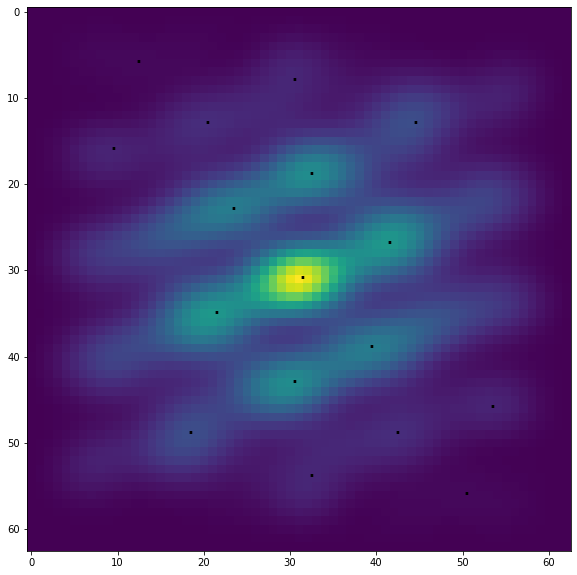

In [5]:
unit=0
img = scipy.signal.correlate(ratemaps[unit], ratemaps[unit], mode='full')

peaks = sm.find_peaks(img)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(img.T)

for peak in peaks:
    ax.annotate('.', xy=peak, fontsize=25)

In [6]:
def env_split(stats, Ng=4096):
    env_stat = []
    for env_i in range(len(environments)):
        tmp = stats[Ng*env_i:Ng*(env_i+1)]
        env_stat.append(tmp)
    return np.array(env_stat)

grid_spacings = np.array(list(map(lambda x: grid_spacing(x)[0], ratemaps)))
grid_spacings = env_split(grid_spacings).T

grid_orientations = np.array(list(map(lambda x: grid_orientation(x)[0], ratemaps)))
grid_orientations = env_split(grid_orientations).T

Text(0.5, 1.0, 'Peak Spacing')

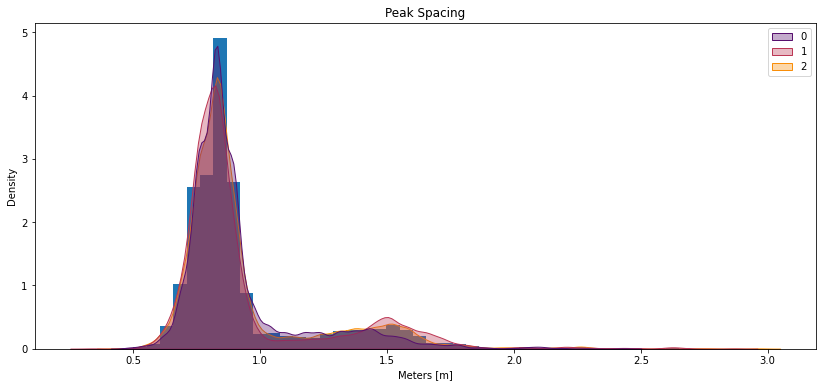

In [7]:
plt.figure(figsize=(14,6))
bw_adjust = 0.5
plt.hist(grid_spacings.flatten(), bins=50, density=True)
sns.kdeplot(data=grid_spacings, bw_adjust=bw_adjust, fill=True, alpha=0.35, palette='inferno', common_norm=False, linewidth=1)
plt.xlabel('Meters [m]')
plt.title('Peak Spacing')

Text(0.5, 1.0, 'Grid orientation (circular plot)')

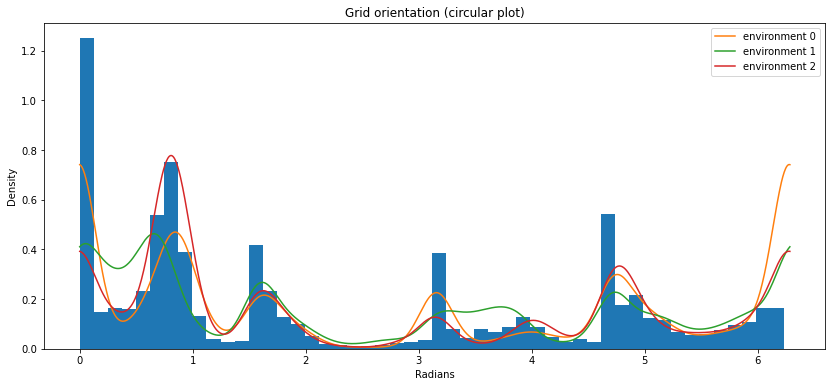

In [8]:
kappa=50
#fig,ax = plt.subplots(figsize=(14,6),subplot_kw={'projection': 'polar'})
fig,ax = plt.subplots(figsize=(14,6))
plt.hist(grid_orientations.flatten(), bins=50, density=True)
theta = np.linspace(0, 2*np.pi, 1001)
for i, grid_orientation_i in enumerate(grid_orientations.T):
    grid_orientation_i = grid_orientation_i[~np.isnan(grid_orientation_i)]
    von_mises_pdf = circular_kernel(grid_orientation_i, kappa=kappa)
    ax.plot(theta, von_mises_pdf(theta), label=f"environment {i}")
plt.xlabel('Radians')
plt.ylabel('Density')
plt.legend()
plt.title('Grid orientation (circular plot)')

In [9]:
# only calculate the upper triangular part of the matrix - since the matrix is symmetric,
# the lower triangular part is a copy of the upper triangular
splitted_ratemaps = env_split(ratemaps)
shifts = np.zeros((len(environments),len(environments), params["Ng"]))
for i in range(len(environments)):
    for j in range(i, len(environments)):
        shifts[i,j] = np.array(list(map(lambda x: phase_shift(*x), zip(splitted_ratemaps[i],splitted_ratemaps[j]))))
upper_flat_triangle = shifts[np.triu_indices(shifts.shape[0],k=1)]

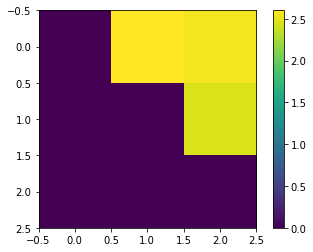

In [10]:
plt.imshow(np.nanmean(shifts,axis=-1))
plt.colorbar()

Text(0, 0.5, 'phase shift')

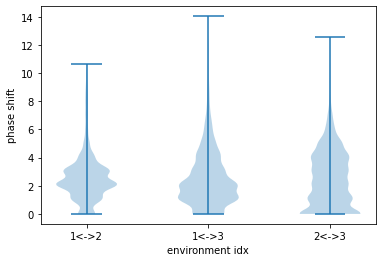

In [11]:
data = []
for env_phase in upper_flat_triangle:
    data.append(env_phase[~np.isnan(env_phase)])
fig,ax = plt.subplots()
ax.violinplot(data)
labels=['1<->2','1<->3','2<->3']
ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
plt.xlabel("environment idx")
plt.ylabel("phase shift")

In [12]:
splitted_ratemaps.shape

(3, 4096, 32, 32)

In [13]:
[mb,c,h,w] * [oc,1,h,w] -> [mb,oc,h,w]
[4096,1,32,32] * [4096,1,32,32] -> [4096,4096,32,32]

SyntaxError: invalid syntax (1879723069.py, line 1)

In [24]:
corrs.shape

(128, 4096, 32, 32)

In [36]:
splitted_ratemaps2.shape

(3, 4096, 32, 32)

In [37]:
splitted_ratemaps = splitted_ratemaps2

In [33]:
splitted_ratemaps2 = splitted_ratemaps

In [38]:
splitted_ratemaps = splitted_ratemaps[:,:256]

In [39]:
splitted_ratemaps.shape

(3, 256, 32, 32)

In [47]:
# this is expensive computations...
# Do GPU computed correlations
# see you tomorrow (assuming you have a nice water cooled computer :) - otherwise: never!)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mb_size = 128
N = splitted_ratemaps.shape[1]

relative_shifts = np.zeros((len(environments), len(environments), N, N, 2))
for env_i in range(len(environments)):
    for env_j in range(env_i, len(environments)):
        for mb in range(0,N,mb_size):
            ratemaps_i = torch.tensor(splitted_ratemaps[env_i,mb:mb+mb_size], device=device)
            ratemaps_j = torch.tensor(splitted_ratemaps[env_j], device=device)
            corrs = torch.nn.functional.conv2d(ratemaps_i[:,None], ratemaps_j[:,None], padding='same').detach().cpu().numpy()
            for ki in tqdm.trange(mb_size):
                for kj in range(N):
                    relative_shifts[env_i,env_j,ki,kj] = phase_shift2(corrs[ki,kj])

100%|█████████████████████████████████████████| 128/128 [00:08<00:00, 14.48it/s]


In [ ]:
relative_shifts[0,0]

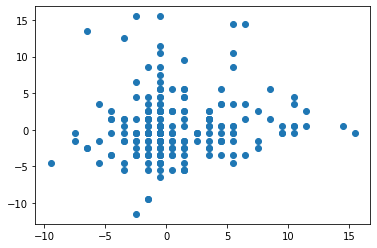

In [81]:
plt.scatter(*relative_shifts[0,0,2].reshape((2,-1)))

In [ ]:
import numpy.ma as ma
ma

In [64]:
tmp.shape

(256, 256, 2)

In [68]:
256**2 * 2

131072

In [84]:
np.isnan(tmp).shape

(256, 256, 2)

In [93]:
256**2 *2

131072

In [97]:
idxs = np.where(np.isnan(tmp))

(60023, 2)


<AxesSubplot:>

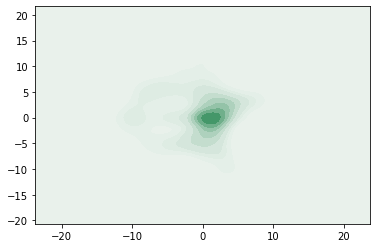

In [222]:
not_bad = np.any(~np.isnan(tmp), axis = (-1))
z = tmp[not_bad]
print(z.shape)
#z = [tmp[not_bad[i]] for i in range(len(tmp)) ]
#for i in range(len(z)):
#    print(z[i].shape)
sns.kdeplot(
    x = z[:10000,0], y = z[:10000,1], 
    fill=True, thresh=0, cmap = sns.light_palette("seagreen", as_cmap=True)
)
#plt.scatter(*z.T, alpha = 1, s = 0.5)
#plt.axis("off")

In [98]:
tmp[idxs[:2]].shape

(11026, 2)

In [ ]:
tmp = np.where(~np.isnan(tmp))

In [71]:
tmp[np.where(~np.isnan(tmp))]

(120046,)

In [67]:
np.sum(np.isnan(tmp))

11026

(3, 3, 256, 256, 2)


<AxesSubplot:>

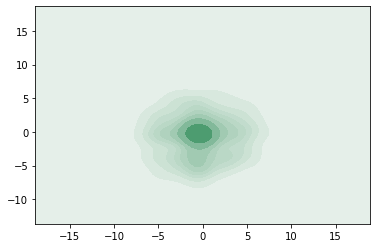

In [221]:
print(relative_shifts.shape)
tmp = (relative_shifts[0,0] - relative_shifts[0,2])

tmp2 = relative_shifts[0,2]
not_bad = np.any(~np.isnan(tmp2), axis = (-1))
z = tmp2[not_bad]

sns.kdeplot(
    x = z[:1000,0], y = z[:1000,1], 
    fill=True, thresh=0, cmap = sns.light_palette("seagreen", as_cmap=True)
)
#plt.scatter(*z.T, alpha = 1, s = 0.5)
#plt.axis("off")

In [45]:
relative_shifts.shape

(3, 3, 256, 256, 2)

In [40]:
# this is expensive computations...
# Do GPU computed correlations
# see you tomorrow (assuming you have a nice water cooled computer :) - otherwise: never!)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mb_size = 128

relative_shifts = np.zeros((len(environments), len(environments), params["Ng"], params["Ng"], 2))
for env_i in range(len(environments)):
    for env_j in range(i, len(environments)):
        for mb in range(0,params["Ng"]-mb_size,mb_size):
            ratemaps_i = torch.tensor(splitted_ratemaps[env_i,mb:mb+mb_size], device=device)
            ratemaps_j = torch.tensor(splitted_ratemaps[env_j], device=device)
            corrs = torch.nn.functional.conv2d(ratemaps_i[:,None], ratemaps_j[:,None], padding='same').detach().cpu().numpy()
            for k in tqdm.trange(params["Ng"]*mb_size):
                phase_shift2(corrs.reshape((-1,32,32))[k])

  4%|█▏                                | 18760/524288 [00:05<02:18, 3656.32it/s]


KeyboardInterrupt: 

In [ ]:
corrs[0][0].shape

In [ ]:
ratemaps_i[:,None].shape

In [ ]:
relative_shifts = np.zeros((len(environments), len(environments), params["Ng"], params["Ng"], 2))
for env_i in range(len(environments)):
    for env_j in range(i, len(environments)):
        for ni in tqdm.trange(params["Ng"]):
            for nj in range(params["Ng"]):
                relative_shifts[env_i,env_j,ni,nj] = phase_shift(splitted_ratemaps[env_i,ni], splitted_ratemaps[env_j,nj], norm=False)